In [1]:
#import importlib.util
#import sys
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)
#%cd 'gdrive/My Drive/annotations_imparfaites/'

# Etude de l'influence de l'annotation pour l'apprentissage profond

L'apprentissage profond (deep learning) permet d'atteindre les
meilleurs résultats dans de nombreuses tâches de traitement d'image.
Néanmoins, cette méthode requiert une base de données annotées, c'est
à dire des images sur lesquelles la tâche en question a déjà été
réalisée, le plus souvent manuellement, par un être humain.

Dans de nombreux cas réels (notamment dans l'industrie et dans le
domaine bio-médical), les annotations manuelles font défaut ou sont
partielles ou imprécises, à cause de la pénibilité de la tâche et du
volume de données nécessaire à l'apprentissage.

On se demande donc si l'on peut se contenter d'annotations imparfaites
pour un apprentissage réussi, et dans quelles limites. En effet, si
des annotations parfaites et complètes s'avéraient non nécessaires,
ceci permettrait de limiter le travail d'annotation à une tâche plus
rapide et grossière, voire de remplacer tout à fait l'annotation
manuelle par un algorithme imparfait mais ne nécessitant pas
d'apprentissage.

## Les données

L'étude sera menée sur des images synthétiques représentant des anneaux de différents niveaux de gris, rendus plus ou moins difficiles à détecter par un bruit ajouté ("noisy image").

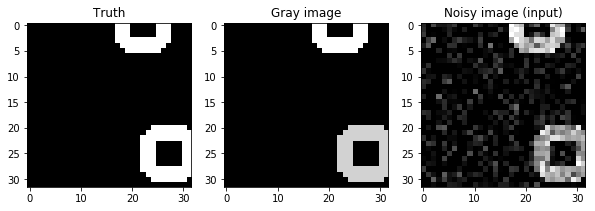
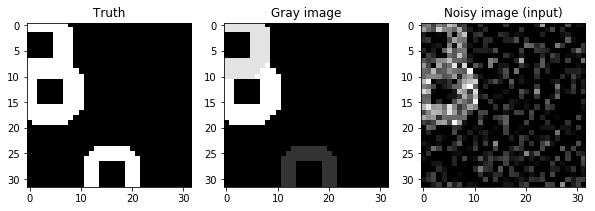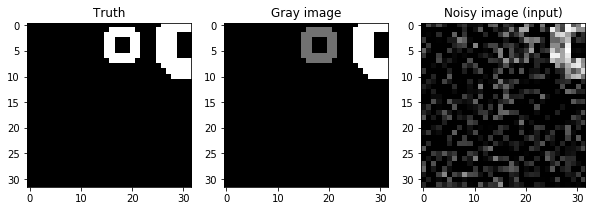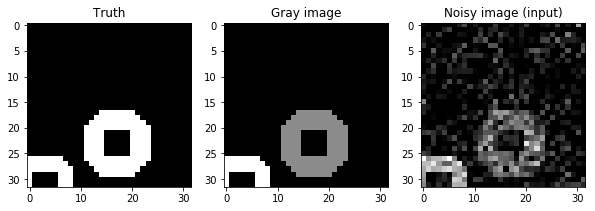

Un réseau de neurones de type U-net est capable d'apprendre à segmenter les anneaux de façon assez précise, lorsqu'on l'entraîne avec des données parfaitement annotées. Comment se dégradent les performances lorsqu'on diminue la qualité de l'annotation ? Cela dépend-il de la nature de la perturbation ?

### Chargement de librairies et fichiers annexes

In [1]:
#%tensorflow_version 1.x
import tensorflow as tf
print('Using Tensorflow version', tf.__version__)
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1"
#from tensorflow.compat.v1.keras.backend import set_session
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#config.log_device_placement = True  # to log device placement (on which device the operation ran)
#sess = tf.compat.v1.Session(config=config)
#set_session(sess)

import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.callbacks import EarlyStopping, CSVLogger
from keras.models import model_from_json
import matplotlib.pyplot as plt

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2

# local package
from dlia_tools.u_net import u_net
from dlia_tools.keras_image2image import DeadLeavesWithSegmGenerator
from dlia_tools.keras_custom_loss import jaccard2_loss
from dlia_tools.random_image_generator import AdditiveGaussianNoise, draw_ring #, addGaussianNoise
from dlia_tools.random_image_generator import ROG_disks, ROG_rings, RandomPosGenUniform, RandomIntGenUniform
from dlia_tools.eval import jaccard

/usr/local/envs/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/envs/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/envs/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/envs/anaconda3/envs/keras/lib

Using Tensorflow version 1.7.0


Using TensorFlow backend.


### Paramètres pour la création de la base d'images synthétiques

In [2]:
# ****  input data generator parameters
img_rows, img_cols = 32, 32 # dimension des images
img_channels = 1 # nombre de canaux par image
gauss_n_std = 40 # écart type du bruit blanc qui sera ajouté
nb_obj_l = 1 # nombre minimal d'anneaux par image
nb_obj_h = 4 # nombre maximal d'anneaux par image
#r1_disk_l = 2
#r1_disk_h = 4
r1_ring_l = 4 # rayon extérieur minimal
r1_ring_h = 8 # rayon extérieur maximal
rad_ratio= 0.5 # rapport rayon intérieur/rayon extérieur
gray_l = 20 # niveau de gris minimum
gray_h = 200 # niveau de gris maximum
norm = 255  # constante de normalisation

img_number=11100 # nombre total d'images dans la base (train:10000 + val:1000 + test:100)

# Création de la base d'images

## Echantillonage des paramètres de la vérité terrain (VT)

La vérité terrain (VT) de chaque image est déterminée par les paramètres suivants :

- le nombre d'anneaux
- la centre de chaque anneau
- le rayon extérieur de chaque anneau

On échantillonne ces paramètres suivant des lois uniformes et on les enregistre afin de fixer la VT.
Ce sont ces paramètres qu'on modifiera pour produire une vérité terrain perturbée (VP). On en profite pour assigner également un niveau de gris aléatoire à chaque anneau, en vue de la suite.

In [3]:
data=np.zeros((img_number, nb_obj_h, 5), dtype=int)
for i in range(img_number):
    n_rings = np.random.randint(nb_obj_l, nb_obj_h+1)
    for j in range(n_rings):
        centre_x=np.random.randint(0, img_rows)
        centre_y=np.random.randint(0, img_cols)
        r1=np.random.randint(r1_ring_l, r1_ring_h)
        v=np.random.randint(gray_l, gray_h)
        data[i][j]=np.array([1,centre_x, centre_y, r1, v])

In [5]:
np.savez('data',data=data) # enregistrement des paramètres de la VT

## Création des images à segmenter

À partir des paramètres de la VT, il reste à 

- créer les images binaires correspondantes
- appliquer à chaque anneau son niveau de gris,
- ajouter un bruit


In [6]:
noise = AdditiveGaussianNoise(gauss_n_std)
img_gt=np.zeros((img_number,img_rows,img_cols,1)) # images binaires
img_gray=np.zeros((img_number,img_rows,img_cols,1)) # images à niveaux de gris
img_noise=np.zeros((img_number,img_rows,img_cols,1)) # images bruitées
for i in range(img_number):
    im1=img_gray[i,:,:,0]
    im2=img_gt[i,:,:,0]
    n_rings = data[i, :, 0].sum()
    for j in range(n_rings):
        if data[i][j][0]==1:
            x=data[i][j][1]
            y=data[i][j][2]
            r1=data[i][j][3]
            r2=int(r1*rad_ratio)
            v=data[i][j][4]
            draw_ring(im1,x,y,r1,r2,v)
            draw_ring(im2,x,y,r1,r2,1)
    #img_noise[i,:,:,0]=addGaussianNoise(im1,gauss_n_std)
    img_noise[i,:,:,0]=im1
    noise(img_noise[i,:,:,0])

In [7]:
np.savez('img_noise',img_noise=img_noise)

Text(0.5, 1.0, 'Noisy image (input)')

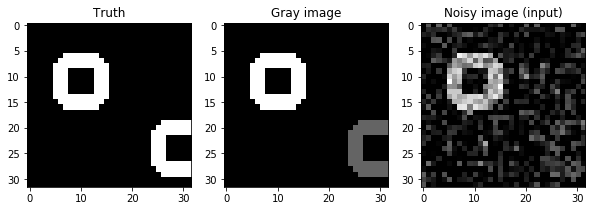

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.random.randint(img_gt.shape[0])
plt.subplot(1, 3, 1)
plt.imshow(img_gt[index, :, :, 0])
plt.title("Truth")
plt.subplot(1, 3, 2)
plt.imshow(img_gray[index, :, :, 0])
plt.title("Gray image")
plt.subplot(1, 3, 3)
plt.imshow(img_noise[index, :, :, 0])
plt.title("Noisy image (input)")

In [9]:
del img_noise
del img_gt
del img_gray
del data

# Chargement des images bruitées et de la VT

In [10]:
data=np.load('data.npz')['data'] # array of rings' parameters for each im: presence, center, radia, gray lev.
img_noise=np.load('img_noise.npz')['img_noise'] # noisy images
img_number = data.shape[0]

### On reproduit les images binaires et à niveaux de gris à partir des paramètres enregistrés.

In [11]:
img_gray=np.zeros((img_number,img_rows,img_cols,1))
img_gt=np.zeros((img_number,img_rows,img_cols,1))
for i in range(img_number):
    im1=img_gray[i,:,:,0]
    im2=img_gt[i,:,:,0] 
    n_rings = data[i, :, 0].sum()
    for j in range(n_rings):
        if data[i][j][0]==1:
            x=data[i][j][1]
            y=data[i][j][2]
            r1=data[i][j][3]
            r2=int(r1*rad_ratio)
            v=data[i][j][4]
            draw_ring(im1,x,y,r1,r2,v)
            draw_ring(im2,x,y,r1,r2,1)

Text(0.5, 1.0, 'Noisy image (input)')

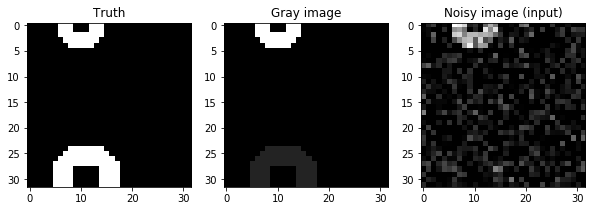

In [12]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.random.randint(img_gt.shape[0])
plt.subplot(1, 3, 1)
plt.imshow(img_gt[index, :, :, 0])
plt.title("Truth")
plt.subplot(1, 3, 2)
plt.imshow(img_gray[index, :, :, 0])
plt.title("Gray image")
plt.subplot(1, 3, 3)
plt.imshow(img_noise[index, :, :, 0])
plt.title("Noisy image (input)")

Text(0.5, 1.0, 'Noisy image (input)')

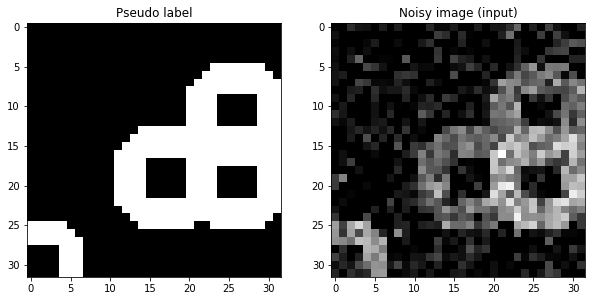

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.random.randint(img_gt.shape[0])
plt.subplot(1, 2, 1)
plt.imshow(img_gt[index, :, :, 0])
plt.title("Pseudo label")
plt.subplot(1, 2, 2)
plt.imshow(img_noise[index, :, :, 0])
plt.title("Noisy image (input)")

# Apprentissage de la segmentation

### Partition des données en bases d'entraînement, de validation et de test.

In [14]:
n_train = 10000
n_val = 1000
n_test = 100
Y_train=img_gt[:n_train,:,:,:]
Y_val=img_gt[n_train:n_train+n_val,:,:,:]
Y_test=img_gt[n_train+n_val:n_train+n_val+n_test,:,:,:]

X_train=img_noise[:n_train,:,:,:]
X_val=img_noise[n_train:n_train+n_val,:,:,:]
X_test=img_noise[n_train+n_val:n_train+n_val+n_test,:,:,:]

### Architecture (U-net), paramètres d'optimisation

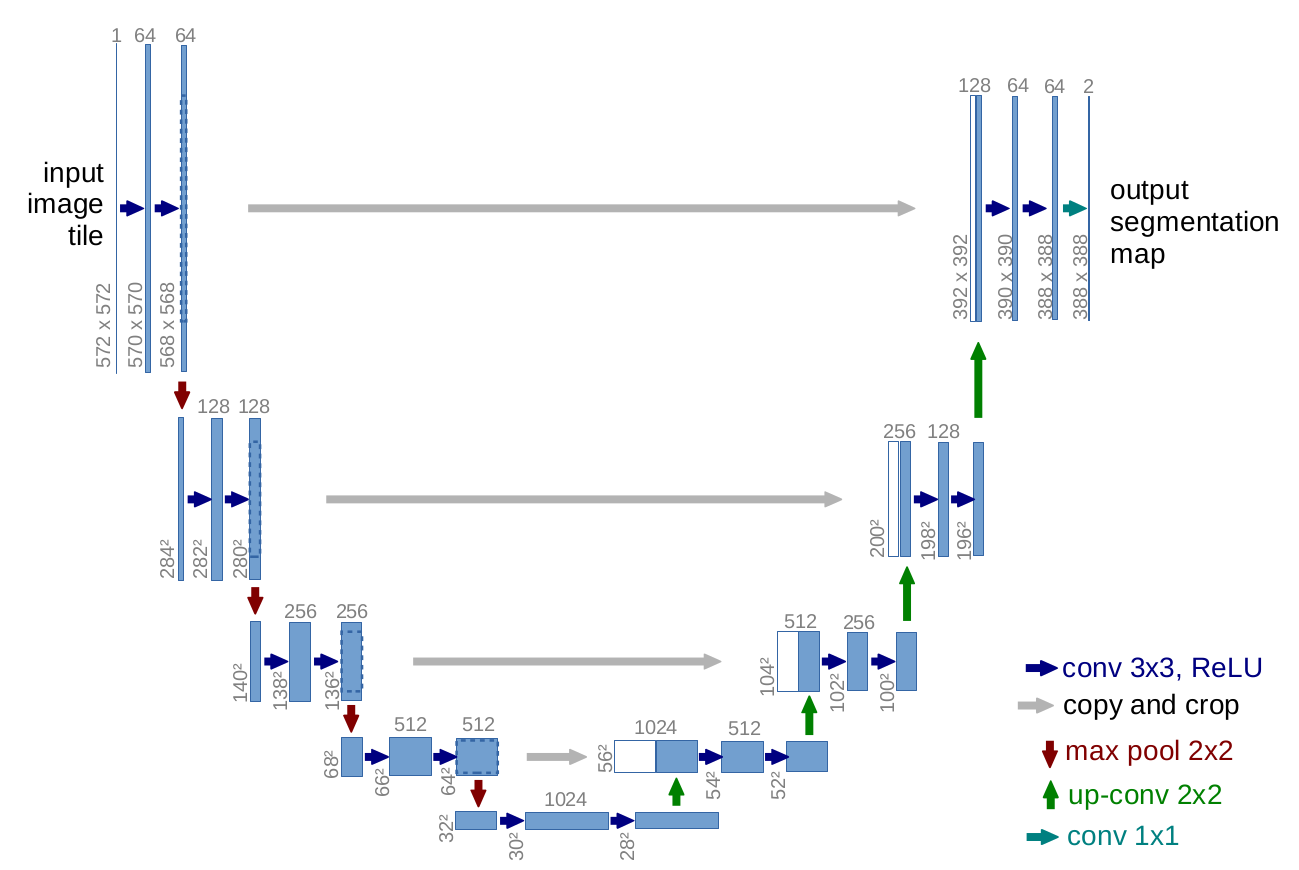

In [15]:
# architecture params
nb_filters_0 = 8
sigma_noise = 0.01

# ****  deep learning model
shape = (img_rows, img_cols, img_channels)
model = u_net(shape, nb_filters_0, sigma_noise=sigma_noise)

# ****  train
opt_name = 'sgd'  # choices:adadelta; sgd, rmsprop, adagrad, adam
loss_func = jaccard2_loss  # mse, mae, binary_crossentropy, jaccard2_loss
if opt_name == "sgd":
    opt = SGD(lr=0.1)
elif opt_name == "rmsprop":
    opt = RMSprop()
elif opt_name == "adagrad":
    opt = Adagrad()
elif opt_name == "adadelta":
    opt = Adadelta()
elif opt_name == "adam":
    opt = Adam(lr=1e-5)
else:
    raise NameError("Wrong optimizer name")
model.compile(loss=loss_func, optimizer=opt)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 8)    584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 8)    0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

### Entraînement

In [16]:
# fit params
batch_size = 128
nb_epoch = 4000 # nb. max d'époques
patience = 20 # nb max. d'époques sans amélioration de la validation loss
# Early stopping
es= EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto', restore_best_weights=True)
# Save training metrics regularly
csv_logger = CSVLogger('training_control.log')

verbose = 1
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=verbose,
                    callbacks=[es, csv_logger])

Train on 10000 samples, validate on 1000 samples
Epoch 1/4000
10000/10000 [==============================] - 16s 2ms/step - loss: 0.6800 - val_loss: 0.4314
Epoch 2/4000
10000/10000 [==============================] - 2s 153us/step - loss: 0.3298 - val_loss: 0.2176
Epoch 3/4000
10000/10000 [==============================] - 1s 134us/step - loss: 0.2462 - val_loss: 0.1916
Epoch 4/4000
10000/10000 [==============================] - 1s 149us/step - loss: 0.2236 - val_loss: 0.1798
Epoch 5/4000
10000/10000 [==============================] - 2s 153us/step - loss: 0.2003 - val_loss: 0.2272
Epoch 6/4000
10000/10000 [==============================] - 1s 148us/step - loss: 0.1892 - val_loss: 0.1895
Epoch 7/4000
10000/10000 [==============================] - 1s 138us/step - loss: 0.1842 - val_loss: 0.1604
Epoch 8/4000
10000/10000 [==============================] - 1s 144us/step - loss: 0.1746 - val_loss: 0.2213
Epoch 9/4000
10000/10000 [==============================] - 1s 150us/step - loss: 0.1742

Epoch 76/4000
10000/10000 [==============================] - 1s 145us/step - loss: 0.1128 - val_loss: 0.1525
Epoch 77/4000
10000/10000 [==============================] - 1s 145us/step - loss: 0.1127 - val_loss: 0.1261
Epoch 78/4000
10000/10000 [==============================] - 2s 152us/step - loss: 0.1105 - val_loss: 0.1211
Epoch 79/4000
10000/10000 [==============================] - 2s 154us/step - loss: 0.1139 - val_loss: 0.1146
Epoch 80/4000
10000/10000 [==============================] - 2s 154us/step - loss: 0.1130 - val_loss: 0.1154
Epoch 81/4000
10000/10000 [==============================] - 1s 142us/step - loss: 0.1122 - val_loss: 0.2548
Epoch 82/4000
10000/10000 [==============================] - 1s 147us/step - loss: 0.1132 - val_loss: 0.1655
Epoch 83/4000
10000/10000 [==============================] - 1s 130us/step - loss: 0.1130 - val_loss: 0.1717
Epoch 84/4000
10000/10000 [==============================] - 1s 142us/step - loss: 0.1121 - val_loss: 0.1562
Epoch 85/4000
10000

In [17]:
# **** #####################################"
print("Best validation loss: %.5f" % (np.min(history.history['val_loss'])))
print("at: %d" % np.argmin(history.history['val_loss']))

Best validation loss: 0.10954
at: 110


#### Sauvegarde du modèle entraîné

In [18]:
# serialize weights to HDF5
model.save_weights("model_control.h5")
print("Saved model to disk")

Saved model to disk


#### Visualisation des courbes d'apprentissage

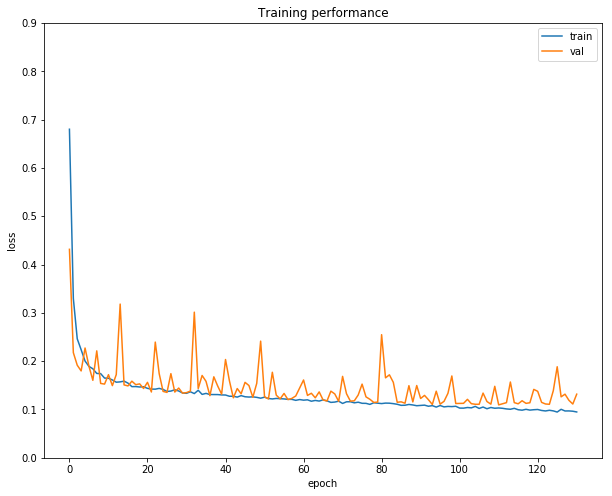

In [19]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.0, 0.9)
plt.show()

#### Lecture d'un modèle précédemment entraîné

Afin de récupérer le modèle précédemment entraîné, on définit un nouveau modèle de même architecture, et on charge les paramètres sauvegardés.

In [20]:
# architecture params
nb_filters_0 = 8
sigma_noise = 0.01

# ****  deep learning model
shape = (img_rows, img_cols, img_channels)
modelLoaded = u_net(shape, nb_filters_0, sigma_noise=sigma_noise) # même architecture que précédemment

modelLoaded.load_weights("model_control.h5")

#### Application du modèle aux données de test

In [21]:
Y_pred = modelLoaded.predict(X_test)

#### Visualisation de résultats

input image, ground truth, segmentation by the network.


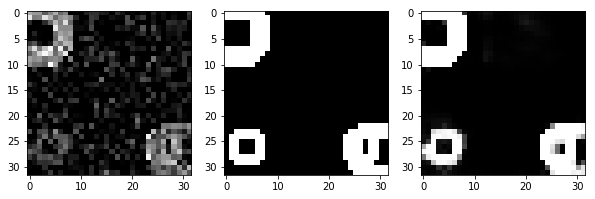

In [22]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
index = np.random.randint(X_test.shape[0])
plt.subplot(1, 3, 1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[index,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[index,:,:,0])
print('input image, ground truth, segmentation by the network.')

# Comparaison de deux (ensembles d') images par l'indice de Jaccard

L'indice de Jaccard est une mesure de ressemblance entre deux ensembles $A$ et $B$:

$$
J(A, B) = \frac{A\cap B}{A\cup B}
$$


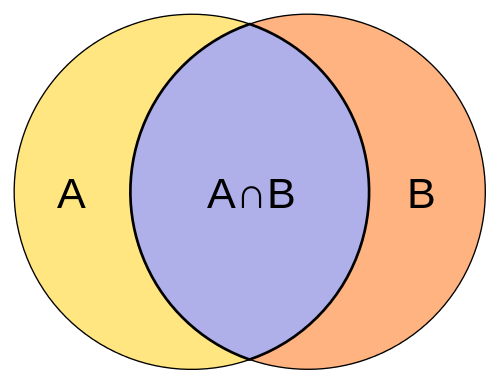

On peut l'étendre naturellement aux images binaires et à niveaux de gris :

$$
J(y, \hat{y}) = \frac{\sum_i y_i \hat{y}_i}{\sum_i y_i + \sum_i\hat{y}_i - \sum_i y_i \hat{y}_i}
$$

In [23]:
# Quantitative evaluation
from dlia_tools.eval import jaccard

Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

print("Jaccard on training set:", jaccard(Y_train, Y_train_pred))
print("Jaccard on validation set:", jaccard(Y_val, Y_val_pred))
print("Jaccard on test set:", jaccard(Y_test, Y_test_pred))

Jaccard on training set: 0.8212952856470416
Jaccard on validation set: 0.8113278840984935
Jaccard on test set: 0.8142736572100574


# Chargement des images bruitées et perturbation de la VT

In [24]:
data=np.load('data.npz')['data'] # array of rings' parameters for each im: presence, center, radia, gray lev.
img_noise=np.load('img_noise.npz')['img_noise'] # noisy images
img_number = data.shape[0]

### On reproduit les images à niveaux de gris à partir des paramètres enregistrés. Les images binaires d'annotation imparfaite sont construites en oubliant certains anneaux avec une probabilité <code> proba_oversight</code>.

In [25]:
proba_oversight = 0.1

img_gray=np.zeros((img_number,img_rows,img_cols,1))
img_gt=np.zeros((img_number,img_rows,img_cols,1))
img_imp_gt=np.zeros((img_number,img_rows,img_cols,1))
for i in range(img_number):
    im1=img_gray[i,:,:,0]
    im2=img_gt[i,:,:,0]
    im3=img_imp_gt[i,:,:,0] 
    n_rings = data[i, :, 0].sum()
    for j in range(n_rings):
        if data[i][j][0]==1:
            x=data[i][j][1]
            y=data[i][j][2]
            r1=data[i][j][3]
            r2=int(r1*rad_ratio)
            v=data[i][j][4]
            draw_ring(im1,x,y,r1,r2,v)
            draw_ring(im2,x,y,r1,r2,1)
            if np.random.rand() > proba_oversight :
                draw_ring(im3,x,y,r1,r2,1)

Text(0.5, 1.0, 'Noisy image (input)')

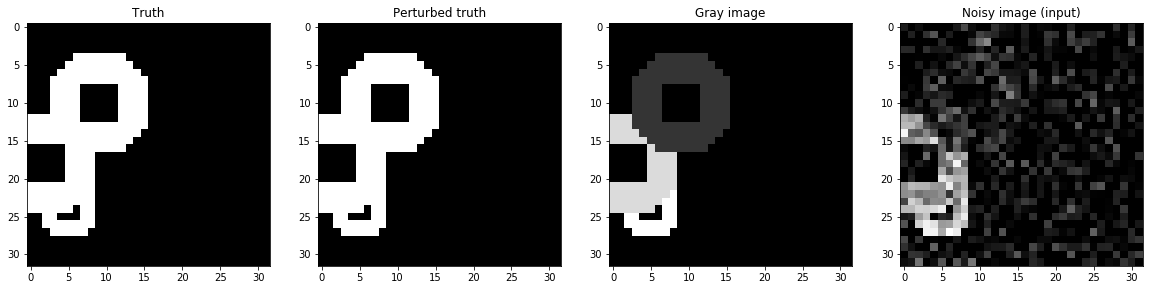

In [26]:
plt.figure(figsize=(20.0, 10.0))
index = np.random.randint(img_imp_gt.shape[0])
plt.subplot(1, 4, 1)
plt.imshow(img_gt[index, :, :, 0])
plt.title("Truth")
plt.subplot(1, 4, 2)
plt.imshow(img_imp_gt[index, :, :, 0])
plt.title("Perturbed truth")
plt.subplot(1, 4, 3)
plt.imshow(img_gray[index, :, :, 0])
plt.title("Gray image")
plt.subplot(1, 4, 4)
plt.imshow(img_noise[index, :, :, 0])
plt.title("Noisy image (input)")

# Apprentissage de la segmentation sur annotations imparfaites

### Partition des données en bases d'entraînement, de validation et de test.

In [27]:
n_train = 10000
n_val = 1000
n_test = 100
Y_train=img_imp_gt[:n_train,:,:,:]
Y_val=img_imp_gt[n_train:n_train+n_val,:,:,:]
Y_test=img_gt[n_train+n_val:n_train+n_val+n_test,:,:,:]

X_train=img_noise[:n_train,:,:,:]
X_val=img_noise[n_train:n_train+n_val,:,:,:]
X_test=img_noise[n_train+n_val:n_train+n_val+n_test,:,:,:]

### Comparaison entre vérité terrain et annotation imparfaite (vérité terrain avec oubli)

In [28]:
print("Jaccard between training labels and ground truth:", jaccard(Y_train, img_gt[:n_train,:,:,:]))

Jaccard between training labels and ground truth: 0.9074879752167179


### Même architecture et paramètres d'entraînement que précédemment.

In [29]:
model_new = u_net(shape, nb_filters_0, sigma_noise=sigma_noise)
model_new.compile(loss=loss_func, optimizer=opt)
print(model_new.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 8)    80          input_3[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 8)    584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 8)    0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

### Entraînement

In [30]:
# Save training metrics regularly
param_str = str(int(100*proba_oversight))
csv_logger = CSVLogger('training_log_oubli'+param_str+'.log')

verbose = 1
history = model_new.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=verbose,
                    callbacks=[es, csv_logger])

Train on 10000 samples, validate on 1000 samples
Epoch 1/4000
10000/10000 [==============================] - 2s 244us/step - loss: 0.7809 - val_loss: 0.5908
Epoch 2/4000
10000/10000 [==============================] - 1s 141us/step - loss: 0.4930 - val_loss: 0.3966
Epoch 3/4000
10000/10000 [==============================] - 1s 150us/step - loss: 0.3382 - val_loss: 0.3461
Epoch 4/4000
10000/10000 [==============================] - 2s 151us/step - loss: 0.2966 - val_loss: 0.5432
Epoch 5/4000
10000/10000 [==============================] - 2s 157us/step - loss: 0.2807 - val_loss: 0.3531
Epoch 6/4000
10000/10000 [==============================] - 2s 150us/step - loss: 0.2687 - val_loss: 0.3232
Epoch 7/4000
10000/10000 [==============================] - 2s 157us/step - loss: 0.2629 - val_loss: 0.3537
Epoch 8/4000
10000/10000 [==============================] - 2s 160us/step - loss: 0.2551 - val_loss: 0.4113
Epoch 9/4000
10000/10000 [==============================] - 2s 152us/step - loss: 0.248

Epoch 76/4000
10000/10000 [==============================] - 1s 149us/step - loss: 0.1954 - val_loss: 0.2316
Epoch 77/4000
10000/10000 [==============================] - 1s 140us/step - loss: 0.1914 - val_loss: 0.2132
Epoch 78/4000
10000/10000 [==============================] - 2s 151us/step - loss: 0.1916 - val_loss: 0.2270
Epoch 79/4000
10000/10000 [==============================] - 1s 150us/step - loss: 0.1931 - val_loss: 0.1976
Epoch 80/4000
10000/10000 [==============================] - 2s 155us/step - loss: 0.1926 - val_loss: 0.2565
Epoch 81/4000
10000/10000 [==============================] - 1s 148us/step - loss: 0.1923 - val_loss: 0.2883
Epoch 82/4000
10000/10000 [==============================] - 1s 146us/step - loss: 0.1922 - val_loss: 0.2144
Epoch 83/4000
10000/10000 [==============================] - 1s 139us/step - loss: 0.1916 - val_loss: 0.2024
Epoch 84/4000
10000/10000 [==============================] - 1s 140us/step - loss: 0.1898 - val_loss: 0.2138
Epoch 85/4000
10000

In [31]:
# **** #####################################"
print("Best validation loss: %.5f" % (np.min(history.history['val_loss'])))
print("at: %d" % np.argmin(history.history['val_loss']))

Best validation loss: 0.19498
at: 74


#### Sauvegarde du modèle entraîné

In [32]:
# serialize weights to HDF5
model_new.save_weights("model_oubli_"+param_str+".h5")
print("Saved model to disk")

Saved model to disk


#### Visualisation des courbes d'apprentissage

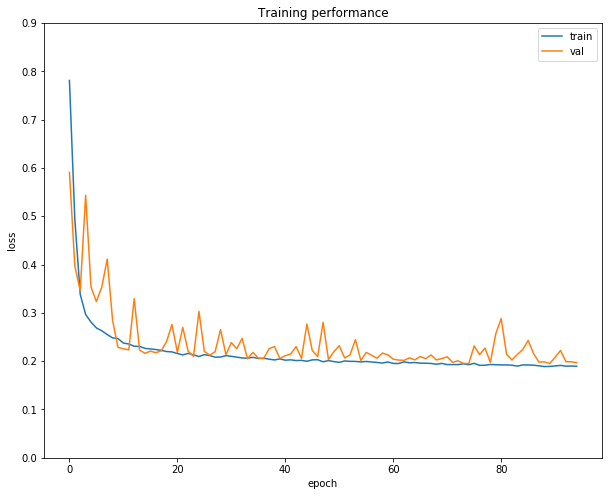

In [33]:
plt.figure(figsize=(10.0, 8.0))
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.0, 0.9)
plt.show()

In [34]:
Y_pred = model_new.predict(X_test)

input image, imperfect ground truth, segmentation by the network.


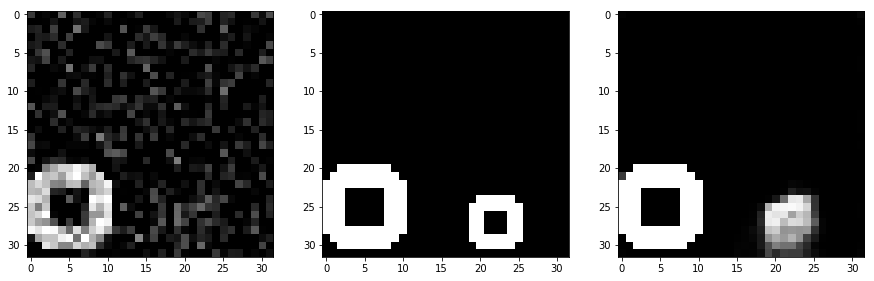

In [35]:
plt.figure(figsize=(15, 10))
index = np.random.randint(X_test.shape[0])
plt.subplot(1, 3, 1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[index,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[index,:,:,0])
print('input image, imperfect ground truth, segmentation by the network.')

In [36]:
#Y_train_pred = model_new.predict(X_train)
#Y_val_pred = model_new.predict(X_val)

#print("Jaccard on training set:", jaccard(Y_train, Y_train_pred))
#print("Jaccard on validation set:", jaccard(Y_val, Y_val_pred))
print("Jaccard on test set:", jaccard(Y_test, Y_pred))

Jaccard on test set: 0.8094894876074671
